In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [3]:
mendel_masses = Table.read('../fits/Simard+Mendel/mendel_masses.fits')
samples = Table.read('../fits/sparcfire/sparcfire_samples.fits')

#### Now, attempt to find some completeness limits?

In [4]:
normal_depth = gz2_data['sample'] != 'stripe82_coadd_1                                                                '
in_spiral = np.all([samples['in_spiral'],samples['axial_ok']],axis=0)

In [5]:
from luminosities_magnitudes_and_distances import Mag_to_lum, lum_to_solar

def remove_inf(data):
    data[np.isfinite(data) == False] = -999
    return data

mass_total = remove_inf(mendel_masses['bulge+disc'])
has_mass = mass_total > 0
sample_ok = np.all([has_mass,normal_depth,in_spiral],axis=0)

print('{}/{} normal depth spirals have masses!'.format(sample_ok.sum(),
                                                       len(sample_ok)))

galaxy_table = Table()
galaxy_table['mass'] = mass_total[sample_ok]
Mr = np.array(gz2_data['PETROMAG_MR'],dtype='float64')[sample_ok]
Lr = lum_to_solar(Mag_to_lum(Mr,6185.19))
galaxy_table['Mr'] = Mr
galaxy_table['Lr'] = Lr
galaxy_table['u-r'] = (gz2_data['PETROMAG_MU'] 
                     - gz2_data['PETROMAG_MR'])[sample_ok]
galaxy_table['M/L'] = galaxy_table['mass'] - galaxy_table['Lr']
galaxy_table['redshift'] = gz2_data['REDSHIFT_1'][sample_ok]
galaxy_table['redshift_error'] = gz2_data['REDSHIFTERR_1'][sample_ok]
galaxy_table['dr7id'] = gz2_data['dr7objid'][sample_ok]
galaxy_table['dr8id'] = gz2_data['dr8objid'][sample_ok]

42654/248883 normal depth spirals have masses!


In [6]:
redshifts = galaxy_table['redshift']
Mags = galaxy_table['Mr']
masses = galaxy_table['mass']

from luminosities_magnitudes_and_distances import Mag_to_lum, lum_to_solar, mag_to_Mag

def pozzetti_mass_completeness(redshifts,Mags,masses,z_lims=(0.02,0.025),
                               mag_limit=17):
    in_redshift = np.all([redshifts >= z_lims[0],redshifts <= z_lims[1]],
                         axis=0)
    
    redshifts_subset = redshifts[in_redshift]
    masses_subset = masses[in_redshift]
    Mags_subset = Mags[in_redshift]
    
    log_Lsolar = lum_to_solar(Mag_to_lum(Mags_subset,6185.19))
    logML = masses_subset - log_Lsolar
    
    Mag_limits = mag_to_Mag(mag_limit,redshifts_subset)
    lum_limits = lum_to_solar(Mag_to_lum(Mag_limits,6815.19))
    mass_limits = logML + np.squeeze(lum_limits)
    
    faintest_20_line = np.percentile(Mags_subset,80)
    in_faintest_20 = Mags_subset >= faintest_20_line
    mass_completeness = np.percentile(mass_limits[in_faintest_20],95)
    
    return mass_completeness, np.mean(redshifts_subset)


def pozzetti_mass_completeness_upper(redshifts,Mags,masses,z_lims=(0.02,0.025),
                                     mag_limit=14):
    in_redshift = np.all([redshifts >= z_lims[0],redshifts <= z_lims[1]],
                         axis=0)
    
    redshifts_subset = redshifts[in_redshift]
    masses_subset = masses[in_redshift]
    Mags_subset = Mags[in_redshift]
    
    log_Lsolar = lum_to_solar(Mag_to_lum(Mags_subset,6185.19))
    logML = masses_subset - log_Lsolar
    
    Mag_limits = mag_to_Mag(mag_limit,redshifts_subset)
    lum_limits = lum_to_solar(Mag_to_lum(Mag_limits,6815.19))
    mass_limits = logML + np.squeeze(lum_limits)
    
    brightest_20_line = np.percentile(Mags_subset,20)
    in_brightest_20 = Mags_subset <= brightest_20_line
    mass_completeness = np.percentile(mass_limits[in_brightest_20],5)
    
    return mass_completeness, np.mean(redshifts_subset)

y_upper=2.452247979752009+-0.08076591946663678 (x) + 14.049447208604361+-0.11692509416288906
y_lower=2.074778050907879+-0.15019090626792855 (x) + 12.644622441713855+-0.21743187878935147


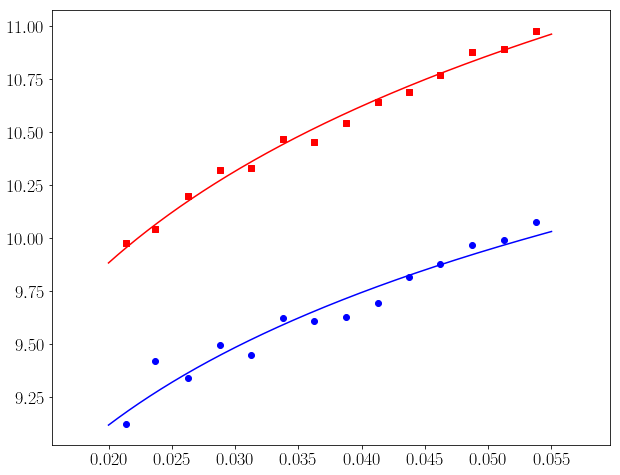

In [12]:
from scipy.optimize import curve_fit

def log(x,m,c):
    return m*np.log10(x) + c

zs = np.linspace(0.02,0.055,15)

z_bins = []
mass_lower_limits = []
mass_upper_limits = []

for z1, z2 in zip(zs[:-1],zs[1:]):
    
    mass_lower, z_ = pozzetti_mass_completeness(redshifts,Mags,masses,(z1,z2))
    mass_upper, _ = pozzetti_mass_completeness_upper(redshifts,Mags,masses,(z1,z2))
    
    z_bins.append(z_)
    mass_lower_limits.append(mass_lower)
    mass_upper_limits.append(mass_upper)
    
#######################################


_ = plt.scatter(z_bins,mass_lower_limits,marker='o',color='b')
_ = plt.scatter(z_bins,mass_upper_limits,marker='s',color='r')

p_lower, p_lower_cov = curve_fit(log,z_bins,mass_lower_limits)
p_lower_error = np.sqrt(np.diag(p_lower_cov))
p_upper, p_upper_cov = curve_fit(log,z_bins,mass_upper_limits)
p_upper_error = np.sqrt(np.diag(p_upper_cov))

x_guide = np.linspace(0.02,0.055,1000)

_ = plt.plot(x_guide,log(x_guide,*p_upper),color='r')
_ = plt.plot(x_guide,log(x_guide,*p_lower),color='b')

print('y_upper={}+-{} (x) + {}+-{}'.format(p_upper[0],p_upper_error[0],
                                           p_upper[1],p_upper_error[1]))

print('y_lower={}+-{} (x) + {}+-{}'.format(p_lower[0],p_lower_error[0],
                                           p_lower[1],p_lower_error[1]))

#### How many galaxies are in our samples?

In [10]:
class GetLimits():
    
    def __init__(self,redshift,Mag,mass,z_limits=(0.02,0.055),
                 mag_upper=14,mag_lower=17,
                 p_lower=p_lower,p_upper=p_upper):
        self.redshift = redshift
        self.Mag = Mag
        self.mass = mass
        self.z_limits = z_limits
        self.lower_Mag_limit = mag_to_Mag(mag_lower,redshift)
        self.upper_Mag_limit = mag_to_Mag(mag_upper,redshift)
        self.lower_mass_limit = log(redshift,*p_lower)
        self.upper_mass_limit = log(redshift,*p_upper)
        
    def in_redshift_limit(self):
        in_redshift_lim = np.all([self.redshift >= self.z_limits[0],
                                    self.redshift <= self.z_limits[1]],axis=0)
        return in_redshift_lim
    
    def in_Mag_limit(self):
        in_Mag_lim = np.all([self.Mag <= self.lower_Mag_limit,
                             self.Mag >= self.upper_Mag_limit],axis=0)
        return in_Mag_lim
    
    def in_mass_limit(self):
        in_mass_lim = np.all([self.mass >= self.lower_mass_limit,
                             self.mass <= self.upper_mass_limit],axis=0)
        return in_mass_lim

In [11]:
lims = GetLimits(galaxy_table['redshift'],galaxy_table['Mr'],galaxy_table['mass'])

in_zl = lims.in_redshift_limit()
in_vl = lims.in_redshift_limit()*lims.in_Mag_limit()
in_ml = lims.in_redshift_limit()*lims.in_Mag_limit()*lims.in_mass_limit()

print('z-limited spirals: {}'.format(in_zl.sum()))
print('lum.-limited spirals: {}'.format(in_vl.sum()))
print('M*-limited spirals: {}'.format(in_ml.sum()))

z-limited spirals: 12095
lum.-limited spirals: 12042
M*-limited spirals: 7335


../astro_codes/luminosities_magnitudes_and_distances.py:21: RuntimeWarning: divide by zero encountered in log10
  Mag = mag - 5*(np.log10(D/(u.pc))-1)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/units/quantity.py:605: RuntimeWarning: divide by zero encountered in log10
  out = function(inputs[0], obj_array)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


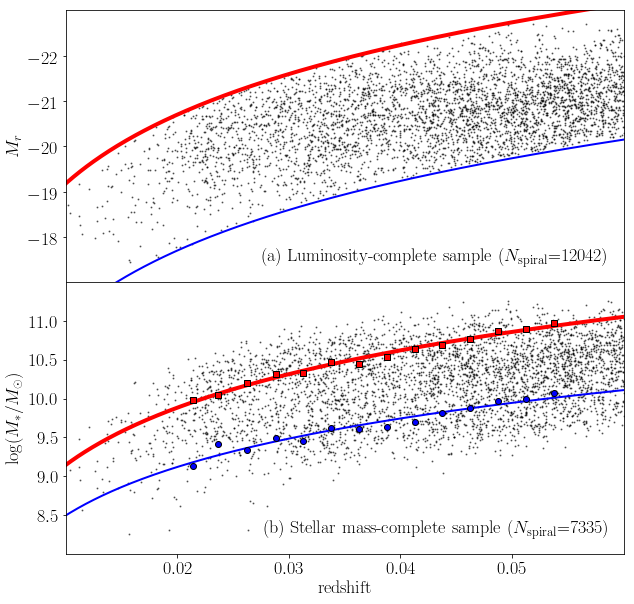

In [19]:
def plot_subset(ax,x,y,N_subset=4000,**kwargs):
    np.random.seed(0)
    N_galaxies = len(x)
    galaxy_indices = range(N_galaxies)
    random_subset = np.random.choice(N_galaxies,N_subset,replace=False)
    _ = ax.scatter(x[random_subset],y[random_subset],**kwargs)
    return None

fig, axarr = plt.subplots(2,1,figsize=(10,10),sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

in_z = np.all([galaxy_table['redshift'] >= 0.01,galaxy_table['redshift'] <= 0.06],
              axis=0)

z_guide = np.linspace(0,0.1,1000)
upper_Mag_guide = mag_to_Mag(14,z_guide)
lower_Mag_guide = mag_to_Mag(17,z_guide)
lower_mass_guide = log(z_guide,*p_lower)
upper_mass_guide = log(z_guide,*p_upper)

ax = axarr[0]
_ = plot_subset(ax,galaxy_table['redshift'][in_z],galaxy_table['Mr'][in_z],
                s=1,color='k',rasterized=True,alpha=0.5)
_ = ax.plot(z_guide,lower_Mag_guide,lw=2,color='b')
_ = ax.plot(z_guide,upper_Mag_guide,lw=4,color='r')

_ = ax.set_ylim(-17,-23)
_ = ax.set_ylabel('$M_r$')


ax = axarr[1]
_ = plot_subset(ax,galaxy_table['redshift'][in_z],galaxy_table['mass'][in_z],
                s=1,color='k',rasterized=True,alpha=0.5,zorder=0)

_ = ax.plot(z_guide,lower_mass_guide,lw=2,color='b',zorder=1)
_ = ax.plot(z_guide,upper_mass_guide,lw=4,color='r',zorder=1)

_ = ax.scatter(z_bins,mass_lower_limits,marker='o',color='b',lw=1,edgecolor='k',
               zorder=2)
_ = ax.scatter(z_bins,mass_upper_limits,marker='s',color='r',lw=1,edgecolor='k',
               zorder=2)

_ = ax.set_ylim(8,11.5)
_ = ax.set_ylabel('$\log(M_*/M_\odot)$')

_ = axarr[1].set_xlabel('redshift')
_ = axarr[1].set_xlim(0.01,0.06)

_ = axarr[0].text(0.975,0.05,
    '(a) Luminosity-complete sample ($N_\mathrm{{spiral}}$={})'.format(in_vl.sum()),
                 transform=axarr[0].transAxes,ha='right',va='bottom')
_ = axarr[1].text(0.975,0.05,
    '(b) Stellar mass-complete sample ($N_\mathrm{{spiral}}$={})'.format(in_ml.sum()),
                 transform=axarr[1].transAxes,ha='right',va='bottom')

fig.savefig('paper_figures/sample_limiting.pdf')

#### Next task: calculate the $V_\mathrm{max}$ correction

In [20]:
def invert_log(mass,m,c):
    z_limit =  10**((mass-c)/m)
    return z_limit

ml_table = galaxy_table[in_ml]
lower_z_limits = invert_log(ml_table['mass'],*p_upper)
upper_z_limits = invert_log(ml_table['mass'],*p_lower)

z_limits = (0.02, 0.055)
lower_z_limits[lower_z_limits < z_limits[0]] = z_limits[0]
upper_z_limits[upper_z_limits > z_limits[1]] = z_limits[1]

z_error = ml_table['redshift_error']

def compute_Vmax(z,scale=True):
    z1, z2 = z
    Vmax = z2**3 - z1**3
    Vmax_weighting = 1/Vmax
    if scale is True:
        Vmax_weighting = Vmax_weighting/np.min(Vmax_weighting)
    return Vmax_weighting

In [21]:
vmax_weights = compute_Vmax((lower_z_limits,upper_z_limits))
log_weights = np.log10(vmax_weights)

7218/7335 have good weights! (98.4%)


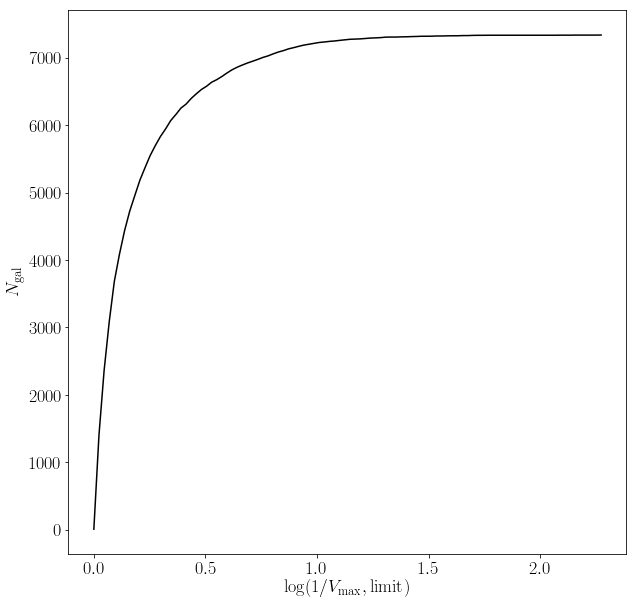

In [22]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

weight_limits = np.linspace(log_weights.min(),log_weights.max(),100)
sample_sizes = []
for weight_limit in weight_limits:
    in_sample = log_weights <= weight_limit
    sample_sizes.append(in_sample.sum())
    
_ = ax.plot(weight_limits,sample_sizes,color='k')
_ = ax.set_xlabel('$\log(1/V_\mathrm{max}, \mathrm{limit})$')
_ = ax.set_ylabel('$N_\mathrm{gal}$')

# Limit at 10:
vmax_ok = vmax_weights <= 10
print('{}/{} have good weights! ({}%)'.format(vmax_ok.sum(),len(vmax_ok),
                    100*np.round(vmax_ok.sum()/len(vmax_ok),decimals=3)))

7062/7335 in error tolerance (96.3%)


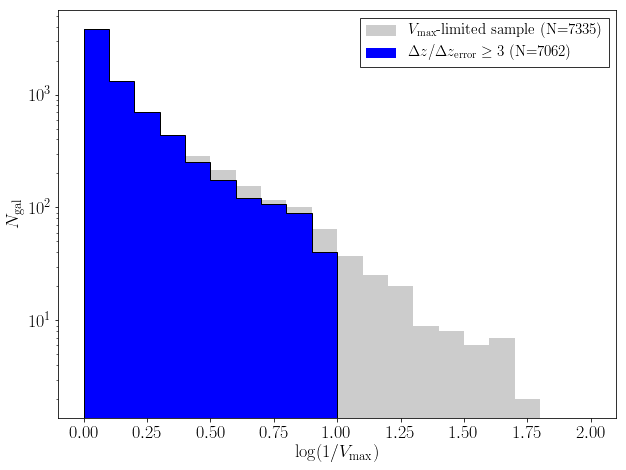

In [23]:
def invert_log_with_errors(mass,m,c,delta_m,delta_c):
    z_limit =  10**((mass-c)/m)
    z_err_c = 10**(mass/m)*(-1/m)*(10**(-c/m))*delta_c
    z_err_m = 10**(mass-c)*(-1/m**2)*(10**(1/m))*delta_m
    z_error = (z_err_m**2 + z_err_c**2)**0.5
    return z_limit, z_error


def compute_Vmax_with_errors(z,z_errors=None,scale=True,tolerance=1):
    z1, z2 = z
    Vmax = z2**3 - z1**3
    Vmax_weighting = 1/Vmax
    if scale is True:
        Vmax_weighting = Vmax_weighting/np.min(Vmax_weighting)
    if z_errors is None:
        return Vmax_weighting
    else:
        z1_error, z2_error = z_errors
        z_distance = z2 - z1
        z_error = (z1_error**2 + z2_error**2)**0.5
        z_mask = z_distance/z_error >= tolerance
        return Vmax_weighting, z_mask

lower_z_limits, lower_z_errors = invert_log_with_errors(ml_table['mass'],
                                                   p_upper[0],p_upper[1],
                                        p_upper_error[0],p_upper_error[1])
upper_z_limits, upper_z_errors = invert_log_with_errors(ml_table['mass'],
                                                   p_lower[0],p_lower[1],
                                        p_lower_error[0],p_lower_error[1])


low_z_mask = lower_z_limits < 0.02
high_z_mask = upper_z_limits > 0.055
lower_z_limits[low_z_mask] = 0.02
lower_z_errors[low_z_mask] = 0
upper_z_limits[high_z_mask] = 0.055
upper_z_errors[high_z_mask] = 0

vmax_weights, z_mask = compute_Vmax_with_errors((lower_z_limits,upper_z_limits),
                                           (lower_z_errors,upper_z_errors),
                                           tolerance=3)

log_weights = np.log10(vmax_weights)

bins = np.linspace(0,2,21)

fig = plt.figure(figsize=(10,7.5))
ax = plt.subplot(111)
_ = ax.hist(log_weights,bins,color='k',alpha=0.2,
            label='$V_\mathrm{{max}}$-limited sample (N={})'.format(len(z_mask)))
_ = ax.hist(log_weights[z_mask],bins,color='b',
            label=r'$\Delta z / \Delta z_\mathrm{{error}} \geq 3$ (N={})'.format(z_mask.sum()))
_ = ax.hist(log_weights[z_mask],bins,histtype='step',color='k')
_ = ax.set_yscale('log')
_ = ax.set_xlabel('$\log(1/V_\mathrm{max})$')
_ = ax.set_ylabel('$N_\mathrm{gal}$')
_ = ax.legend(loc='upper right',fontsize=15,fancybox=False,edgecolor='k')

print('{}/{} in error tolerance ({}%)'.format(z_mask.sum(),len(z_mask),
                    100*np.round(z_mask.sum()/len(z_mask),decimals=3)))

In [ ]:
ml_table['vmax_weight'] = vmax_weights
ml_table['redshift_error_ok'] = z_mask
ml_table['log_vmax_weight'] = log_weights

from combining_catalogues import make_matched_catalogue, match_ids

matched_ids = match_ids(gz2_data,ml_table,'dr7objid','dr7id')
ml_table_matched =  make_matched_catalogue(gz2_data,ml_table,matched_ids)
ml_table_matched['redshift_error_ok'] = ml_table_matched['redshift_error_ok'] == 1

ml_table_matched.write('ml_table_matched.fits',overwrite=True)

#### Next task: match up the catalogues to the GZ2 data, and compare the stellar mass distributions

In [ ]:
def get_gz2_stats(gz2_data,tabulate=True):
    m_colnames = ['t11_arms_number_a31_1_debiased_rh',
                  't11_arms_number_a32_2_debiased_rh',
                  't11_arms_number_a33_3_debiased_rh',
                  't11_arms_number_a34_4_debiased_rh',
                  't11_arms_number_a36_more_than_4_debiased_rh']
    
    w_colnames = ['t10_arms_winding_a28_tight_debiased_rh',
                  't10_arms_winding_a29_medium_debiased_rh',
                  't10_arms_winding_a30_loose_debiased_rh']
    
    m_array = np.array([gz2_data[column] for column in m_colnames]).T
    w_array = np.array([gz2_data[column] for column in w_colnames]).T
    m = np.argmax(m_array,axis=1) + 1
    w = np.argmax(w_array,axis=1) + 1
    m_max = np.max(m_array,axis=1)
    w_max = np.max(w_array,axis=1)
    def measure_wtd_avg(array):
        N_rows, N_columns = np.shape(array)
        wtd_avg = np.zeros(N_rows)
        for c in range(N_columns):
            wtd_avg += array[:,c]*(c+1)
        wtd_avg_sum  = np.sum(array,axis=1)
        return wtd_avg/wtd_avg_sum
    m_wtd_avg = measure_wtd_avg(m_array)
    w_wtd_avg = measure_wtd_avg(w_array)
    p_bar = gz2_data['t03_bar_a06_bar_debiased_rh']
    if tabulate is True:
        table = Table(np.array([m,w,m_max,w_max,m_wtd_avg,w_wtd_avg,p_bar]).T,
            names=('m','w','m_max','w_max','m_wtd_avg','w_wtd_avg','p_bar'))
        return table
    else:
        return m, w, m_max, w_max ,m_wtd_avg, w_wtd_avg, p_bar

In [ ]:
in_ml = ml_table_matched['redshift_error_ok']
gz2_stats = get_gz2_stats(gz2_data[in_ml])
ml_stats = ml_table_matched[in_ml]

fig, axarr = plt.subplots(5,1,figsize=(10,15),sharex=True)
fig.subplots_adjust(hspace=0)

bins = np.linspace(9,11,9)

colors = ('orange','r','m','g','b')
mlabels = ('1','2','3','4','5+')

for m, (ax,color,label) in enumerate(zip(axarr,colors,mlabels)):
    
    in_m = gz2_stats['m'] == m + 1
    mlabel = '$m={} \, (N_\mathrm{{gal}}={})$'.format(label,in_m.sum())
    _ = ax.hist(ml_stats['mass'],bins,normed=True,
                color='k',alpha=0.2,label=None)
    _ = ax.hist(ml_stats['mass'],bins,normed=True,
                histtype='step',color='k',label=None)
    _ = ax.hist(ml_stats['mass'][in_m],bins,normed=True,
                histtype='step',color=color,lw=3,label=mlabel)
    
    _ = ax.set_ylabel('normalised \n density')
    _ = ax.legend(fontsize=15,edgecolor='k',fancybox=False)
    
_ = axarr[-1].set_xlabel(r'$\log(M_*/M_\odot)$')

In [ ]:
mbar_labels = np.zeros(len(ml_data))
mbar_labels[(gz2_stats['m'] == 2) & (gz2_stats['p_bar'] < 0.5)] = 1
mbar_labels[(gz2_stats['m'] == 2) & (gz2_stats['p_bar'] >= 0.5)] = 2
mbar_labels[(gz2_stats['m'] > 2) & (gz2_stats['p_bar'] < 0.5)] = 3
mbar_labels[(gz2_stats['m'] > 2) & (gz2_stats['p_bar'] >= 0.5)] = 4

gz2_stats['mbar_label'] = mbar_labels

In [ ]:
fig, axarr = plt.subplots(4,1,figsize=(10,15),sharex=True)
fig.subplots_adjust(hspace=0)

bins = np.linspace(9,11,9)

colors = ('r','orange','b','purple')
mblabels = ('$m=2$ unbarred','$m=2$ barred',
           '$m>2$ unbarred','$m>2$ barred')

for mb, (ax,color,label) in enumerate(zip(axarr,colors,mblabels)):
    
    in_m = gz2_stats['m'] == mb + 1
    mlabel = '{} $(N_\mathrm{{gal}}={})$'.format(label,in_m.sum())
    _ = ax.hist(ml_stats['mass'],bins,normed=True,
                color='k',alpha=0.2,label=None)
    _ = ax.hist(ml_stats['mass'],bins,normed=True,
                histtype='step',color='k',label=None)
    _ = ax.hist(ml_stats['mass'][in_m],bins,normed=True,
                histtype='step',color=color,lw=3,label=mlabel)
    
    _ = ax.set_ylabel('normalised \n density')
    _ = ax.legend(fontsize=15,edgecolor='k',fancybox=False)
    
_ = axarr[-1].set_xlabel(r'$\log(M_*/M_\odot)$')

In [ ]:
# measure f2 in bins of M*?
from bin_statistics import assign_bins, stats_functions


mass_bins = assign_bins(ml_data['mass'])
mass_means = [np.mean(ml_data['mass'][mass_bins == m]) 
              for m in np.unique(mass_bins)]

colors = ('orange','r','m','g','b')

for m in range(5):
    
    in_m = gz2_stats['m'] == m + 1
    f_m = stats_functions().fraction_with_feature(in_m,mass_bins)

    _ = plt.plot(mass_means,f_m['f'],color=colors[m],lw=3)
    _ = plt.fill_between(mass_means,f_m['f-0.683'],f_m['f+0.683'],
                         color=colors[m],alpha=0.2)
    
_ = plt.xlabel('stellar mass')
_ = plt.ylabel('f')


In [ ]:
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, math.sqrt(variance))

def weighted_percentile(data, percents, weights=None):
    ''' percents in units of 1%
    weights specifies the frequency (count) of data.
    '''
    if weights is None:
        return np.percentile(data, percents)
    ind=np.argsort(data)
    d=data[ind]
    w=weights[ind]
    p=1.*w.cumsum()/w.sum()*100
    y=np.interp(percents, p, d)
    return y


### Make the m-table ####
m_stats_array = np.empty((5,8))

for m in range(5):
    in_m = gz2_stats['m'] == m + 1
    masses_m = ml_stats['mass'][in_m]
    weights_m = ml_stats['vmax_weight'][in_m]
    weighted_percentiles = weighted_percentile(masses_m,(5,25,50,75,95),
                                               weights_m)
    
    mass_mean = np.average(masses_m,weights=weights_m)
    m_stats_row = [m+1,in_m.sum(),mass_mean]
    [m_stats_row.append(w) for w in weighted_percentiles]
    m_stats_array[m,:] = m_stats_row
m_stats_table = Table(m_stats_array,names=('m','N','mass_mean',
                                           '5','25','50','75','95'))

### Now repeat for mb ####
mb_stats_array = np.empty((4,8))

for mb in range(4):
    in_mb = gz2_stats['mbar_label'] == mb + 1
    masses_mb = ml_stats['mass'][in_mb]
    weights_mb = ml_stats['vmax_weight'][in_mb]
    weighted_percentiles = weighted_percentile(masses_mb,(5,25,50,75,95),
                                               weights_mb)
    
    mass_mean = np.average(masses_mb,weights=weights_mb)
    mb_stats_row = [mb+1,in_mb.sum(),mass_mean]
    [mb_stats_row.append(w) for w in weighted_percentiles]
    mb_stats_array[mb,:] = mb_stats_row
mb_stats_table = Table(mb_stats_array,names=('mb','N','mass_mean',
                                           '5','25','50','75','95'))

In [ ]:
def custom_boxplot(ax,medians,boxes,whiskers,**kwargs):
    N_boxes = len(medians)
    arbitrary_data = [np.random.randn(100) for n in range(N_boxes)]
    bp = ax.boxplot(arbitrary_data,**kwargs)
    for n in range(N_boxes):
        bp['medians'][n].set_ydata(medians[n])
        bp['boxes'][n].set_ydata([boxes[0][n],boxes[0][n],
                                  boxes[1][n],boxes[1][n],
                                  boxes[0][n]])
        bp['whiskers'][2*n].set_ydata([boxes[0][n],whiskers[0][n]])
        bp['whiskers'][2*n+1].set_ydata([boxes[1][n],whiskers[1][n]])
        bp['caps'][2*n].set_ydata(whiskers[0][n])
        bp['caps'][2*n+1].set_ydata(whiskers[1][n])
    return None

In [ ]:
fig, axarr = plt.subplots(1,2,figsize=(10,5),sharey=True)
fig.subplots_adjust(wspace=0)

ax = axarr[0]
medians = m_stats_table['50']
boxes = [m_stats_table['25'],m_stats_table['75']]
whiskers = [m_stats_table['5'],m_stats_table['95']]
_ = custom_boxplot(ax,medians,boxes,whiskers,showfliers=False,
                   medianprops={'color':'r'})

ax = axarr[1]
medians = mb_stats_table['50']
boxes = [mb_stats_table['25'],mb_stats_table['75']]
whiskers = [mb_stats_table['5'],mb_stats_table['95']]
_ = custom_boxplot(ax,medians,boxes,whiskers,showfliers=False,
                   medianprops={'color':'r'})

ax.set_ylim(9,11)